# Importing libraries

In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
np.random.seed(42)

# Importing the Iris Dataset


In [2]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

# Hyperparameters

In [3]:
N = 4

# Designing the circuit

In [4]:
def feature_map(X, encoding_type):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if encoding_type == 'rx':
        for i, x in enumerate(X):
            qc.rx(x, i)
    elif encoding_type == 'ry':
        for i, x in enumerate(X):
            qc.ry(x, i)
    elif encoding_type == 'rz':
        for i, x in enumerate(X):
            qc.rz(x, i)    
    return qc, c

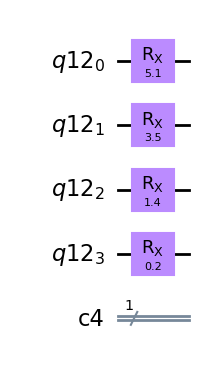

In [23]:
# feature map test
qc,c = feature_map(X[0], 'rx')
qc.draw('mpl')

# Using entanglment and parameteristaion

In [24]:
def variational_circuit(qc, theta, rotation_type):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    if rotation_type == 'rx':
        for i in range(N):
            qc.rx(theta[i], i)
    elif rotation_type == 'ry':
        for i in range(N):
            qc.ry(theta[i], i)
    elif rotation_type == 'rz':
        for i in range(N):
            qc.rz(theta[i], i)
            
    return qc

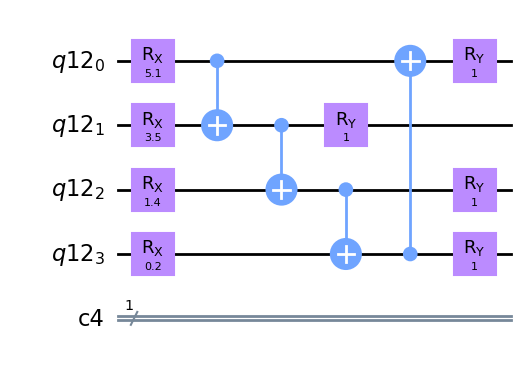

In [25]:
qc = variational_circuit(qc, np.ones(4), 'ry')
qc.draw('mpl')

# Defining the algorithm

In [6]:
def quantum_nn(X, theta, shots, encoding_type, rotation_type, simulator=True):
    
    qc, c = feature_map(X, encoding_type)
    qc = variational_circuit(qc, theta, rotation_type)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [38]:
# quantum_nn test
quantum_nn(X[0], np.ones(4), 5000, 'rx', 'ry')

0.5438

# Defining the loss function

In [7]:
def loss(prediction, target):
    return(prediction-target)**2

In [73]:
# loss test
loss(quantum_nn(X[0], [0.9, 0.9, 0.9, 0.9], 5000, 'rx', 'ry'), Y[0])

0.29877156

# Defining the gradient function (gradient descent)

In [75]:
def gradient(X, Y, theta, delta, shots, encoding_type, rotation_type):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots, encoding_type, rotation_type)
        prediction_2 = quantum_nn(X, theta, shots, encoding_type, rotation_type)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [78]:
gradient(X[0], Y[0], np.ones(4), 0.01, 5000, 'rx', 'ry')

array([-1.727244,  0.844116, -0.10722 , -0.454188])

# Defining Accuracy function

In [83]:
def accuracy(X, Y, theta, shots, encoding_type, rotation_type):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [85]:
# Accuracy test
accuracy(X, Y, [-1.5, 1.2, 0.6, -0.2], 5000, 'rx', 'ry')

0.27

In [10]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

# Training

# Test 1

In [139]:
eta = 0.05

theta = np.ones(N)
N = 4
def model(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    if optimizing_weights==True:
        acc = accuracy(x_test, y_test, get_best_weight(acc_list, weights_list), shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, get_best_weight(acc_list, weights_list), theta, loss_list, acc_list, weights_list
    else:
        acc = accuracy(x_test, y_test, theta, shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, theta, loss_list, acc_list, weights_list

In [142]:
gates = ['rx', 'ry', 'rz']
results = {}
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        print(f'Circuit type : {circuit_type} -> encoding : {encoding_gate} rotation : {rotation_gate}')
        acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, Y_train, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
        results.update({circuit_type: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
        print(f" {circuit_type} accuracy : {results.get(circuit_type).get('accuracy')}")
        

Circuit type : rx-rx -> encoding : rx rotation : rx
Traceback (most recent call last):
  Cell In[142], line 7
    acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, train, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
NameError: name 'train' is not defined

Use %tb to get the full traceback.


In [113]:
theta_x_x, loss_list_x_x, acc_list_x_x, weights_x_x = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rx', rotation_type='rx', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_x_y, loss_list_x_y, acc_list_x_y, weights_x_y = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rx', rotation_type='ry', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_x_z, loss_list_x_z, acc_list_x_z, weights_x_z = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rx', rotation_type='ry', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_y_x, loss_list_y_x, acc_list_y_x, weights_y_x = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='rx', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_y_y, loss_list_y_y, acc_list_y_y, weights_y_y = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_y_z, loss_list_y_z, acc_list_y_z, weights_y_z = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='rz', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_z_x, loss_list_z_x, acc_list_z_x, weights_z_x = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rz', rotation_type='rx', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_z_y, loss_list_z_y, acc_list_z_y, weights_z_y = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rz', rotation_type='ry', delta=0.01)
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
theta_z_z, loss_list_z_z, acc_list_z_z, weights_z_z = model(learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type='rz', rotation_type='rz', delta=0.01)

Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.271 	 0.731 	 [1.7827374 0.9106698 1.2148144 1.1037056] 	 1
1 	 0.234 	 0.791 	 [2.050538  1.0500052 1.196559  1.1153432] 	 2
2 	 0.226 	 0.836 	 [1.8092498 0.9971036 1.5261428 1.0352812] 	 3
3 	 0.223 	 0.851 	 [2.5989272 1.23479   1.6377334 0.714262 ] 	 4
4 	 0.204 	 0.806 	 [2.5978114 1.115771  1.3891058 0.5773252] 	 5
5 	 0.203 	 0.836 	 [2.7728608 1.0027326 1.3111644 0.8602846] 	 6
6 	 0.203 	 0.776 	 [2.9182272 0.7467628 1.2631214 1.0481908] 	 7
7 	 0.2 	 0.851 	 [3.369867  1.1375768 1.3562594 0.8983614] 	 8
8 	 0.202 	 0.866 	 [3.4944944 1.2774464 1.054447  0.905228 ] 	 9
9 	 0.204 	 0.776 	 [3.5878864 1.14444   1.0026526 0.1922292] 	 10
Epoch 	 Loss 	 Training Accuracy 	 theta
0 	 0.376 	 0.299 	 [1.954391  0.9531714 1.6301272 1.3822564] 	 1
1 	 0.275 	 0.716 	 [2.8914508 1.1270764 1.400231  1.2249862] 	 2
2 	 0.201 	 0.866 	 [3.3343526 0.9582848 1.2069716 1.0039362] 	 3
3 	 0.177 	 0.851 	 [3.5790028 1.5013726 1.1347224 0.769584 ]

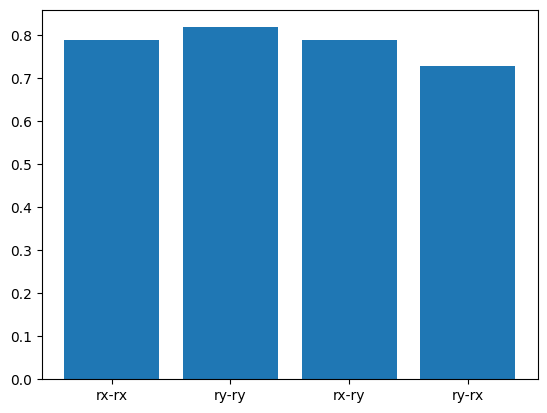

In [127]:
acc_1_1 = accuracy(X_test, Y_test, final_theta_1, 5000, encoding_type='rx', rotation_type='rx')
acc_1_2 = accuracy(X_test, Y_test, final_theta_2, 5000, encoding_type='ry', rotation_type='ry')
acc_1_3 = accuracy(X_test, Y_test, final_theta_3, 5000, encoding_type='rx', rotation_type='ry')
acc_1_4 = accuracy(X_test, Y_test, final_theta_4, 5000, encoding_type='ry', rotation_type='rx')
labels = ['rx-rx', 'ry-ry', 'rx-ry', 'ry-rx']
optimized_results = [acc_1_1, acc_1_2, acc_1_3, acc_1_4]
plt.bar(labels, optimized_results)
plt.show()

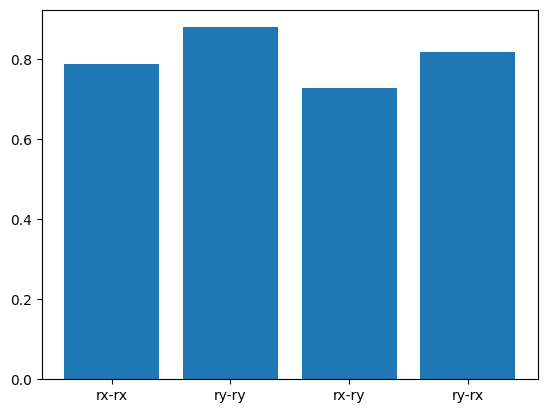

In [128]:
acc_2_1 = accuracy(X_test, Y_test, theta_1, 5000, encoding_type='rx', rotation_type='rx')
acc_2_2 = accuracy(X_test, Y_test, theta_2, 5000, encoding_type='ry', rotation_type='ry')
acc_2_3 = accuracy(X_test, Y_test, theta_3, 5000, encoding_type='rx', rotation_type='ry')
acc_2_4 = accuracy(X_test, Y_test, theta_4, 5000, encoding_type='ry', rotation_type='rx')
labels = ['rx-rx', 'ry-ry', 'rx-ry', 'ry-rx']
natural_results = [acc_2_1, acc_2_2, acc_2_3, acc_2_4]
plt.bar(labels, natural_results)
plt.show()

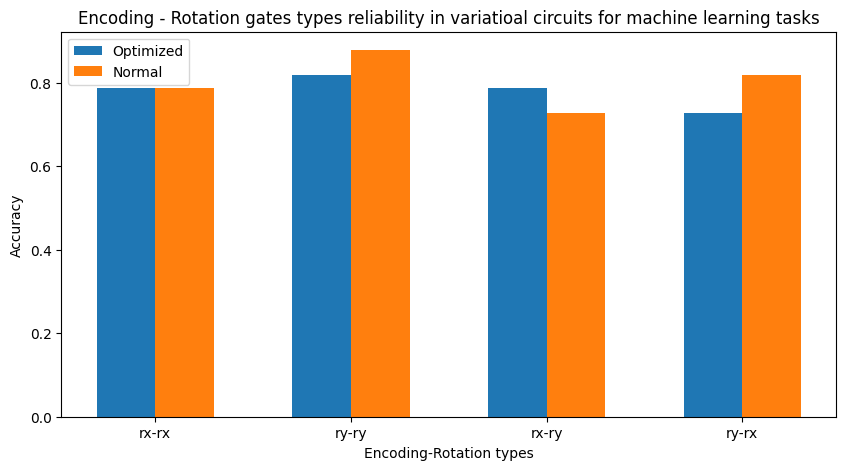

In [132]:
# Numbers of pairs of bars you want
N = 4

# Data on X-axis

# Specify the values of blue bars (height)
optimized_results = [acc_1_1, acc_1_2, acc_1_3, acc_1_4]
# Specify the values of orange bars (height)
natural_results = [acc_2_1, acc_2_2, acc_2_3, acc_2_4]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, optimized_results , width, label='Optimized')
plt.bar(ind + width, natural_results, width, label='Normal')

plt.xlabel('Encoding-Rotation types')
plt.ylabel('Accuracy')
plt.title('Encoding - Rotation gates types reliability in variatioal circuits for machine learning tasks')


labels = ['rx-rx', 'ry-ry', 'rx-ry', 'ry-rx']
# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, labels)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training results')
ax1.plot(loss_list)
ax1.set_title('Loss')
ax2.plot(acc_list)
ax2.set_title('Accuracy')
plt.show()

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

In [ ]:
theta = get_best_weight(acc_list, weights_list)

In [ ]:
accuracy(X_test, Y_test, theta)

# Optimazed trainning (weights saving)

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)
prev_accuracy = 0

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    new_theta = theta
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, new_theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        inner_theta = new_theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            new_theta = inner_theta
            
    if accuracy(X_train, Y_train, new_theta) >= accuracy(X_train, Y_train, theta):
        theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(8, 8)
fig.suptitle('Training results')
ax1.plot(loss_list)
ax1.set_title('Loss')
ax2.plot(acc_list)
ax2.set_title('Accuracy')
plt.show()

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
theta = get_best_weight(acc_list, weights_list)

In [ ]:
accuracy(X_test, Y_test, theta)

# Test with * 2 number of shots (10000)

In [ ]:
def quantum_nn(X, theta, simulator=True):
    
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0, c)

    shots = 10000
    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        shots = 5000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        new_theta = theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)
prev_accuracy = 0

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    new_theta = theta
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, new_theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        inner_theta = new_theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            new_theta = inner_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    if accuracy(X_train, Y_train, new_theta) >= accuracy(X_train, Y_train, theta):
        theta = new_theta
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        new_theta = theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')